# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12789076337958945421
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 4.939s 


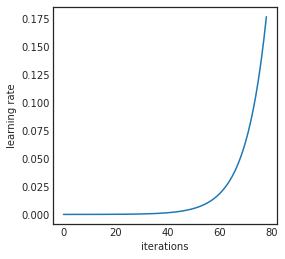

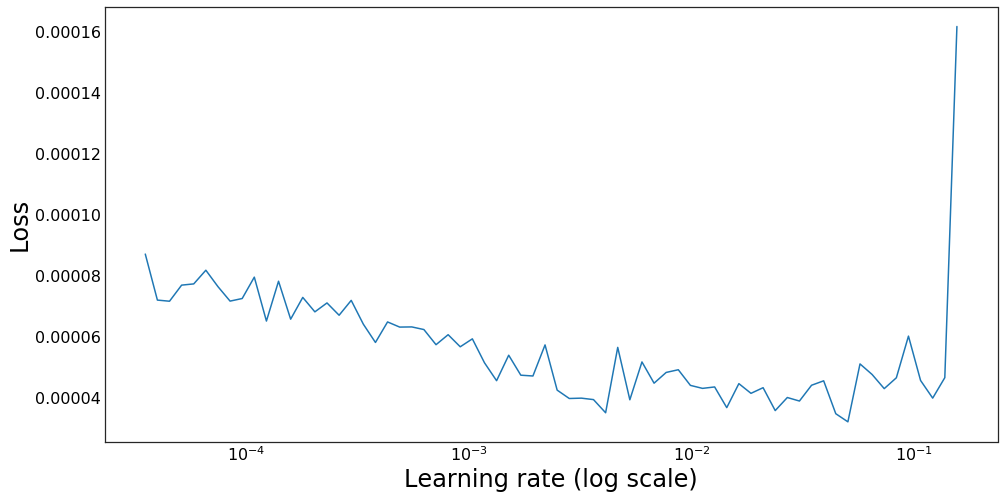

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [6]:
compileArgs['lr'] = 1e-3

In [7]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=10, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1, sgdReplacement=False,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [8]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0 and not self.active:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            self.swa_n = self.n_since_renewal
            if self.sgdReplacement:
                if isinstance(self.losses['base'], type(None)):
                    if self.weighted:
                        self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
                    else:
                        self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
                if self.losses['base'] > new_loss:
                    print("Old average better than current point, starting SGD from old average")
                    self.model.set_weights(self.swa_model)
                    self.n_since_renewal = 0
                else:
                    print("Old average worse than current point, resuming SGD from current point")
                    self.n_since_renewal = 1
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 3.90358993220551e-05
2 New best found: 3.6751092054755895e-05
3 New best found: 3.5383240277541885e-05
4 New best found: 3.513552373735328e-05
5 New best found: 3.4821107644804993e-05
7 New best found: 3.427508485868736e-05
8 New best found: 3.41745336648594e-05
9 New best found: 3.4083592076202884e-05
12 New best found: 3.37233645836497e-05
13 New best found: 3.35761910893096e-05
14 New best found: 3.3362790991276144e-05
19 New best found: 3.324118892494097e-05
23 New best found: 3.295113081231129e-05
31 New best found: 3.286490248427943e-05
36 New best found: 3.283336844089724e-05
37 New best found: 3.2803337741761334e-05
41 New best found: 3.276661236678023e-05
42 New best found: 3.2652349033284674e-05
54 New best found: 3.258783767090537e-05
57 New best found: 3.244674084749157e-05
62 New best found: 3.237227945308783e-05
77 New best found: 3.233752170537498e-05
79 New best found: 

model is 46 epochs old
new model is 46 epochs old
146 swa loss 3.1727731914467635e-05, default loss 3.24204874558945e-05
model is 47 epochs old
new model is 47 epochs old
147 swa loss 3.172602413137335e-05, default loss 3.2156954952005955e-05
147 New best found: 3.172602413137335e-05
model is 48 epochs old
new model is 48 epochs old
148 swa loss 3.1724890331796146e-05, default loss 3.2064896939643126e-05
148 New best found: 3.1724890331796146e-05
model is 49 epochs old
new model is 49 epochs old
149 swa loss 3.172195391958597e-05, default loss 3.2222831200075034e-05
149 New best found: 3.172195391958597e-05
model is 50 epochs old
new model is 50 epochs old
150 swa loss 3.1715499870915037e-05, default loss 3.195914812041691e-05
150 New best found: 3.1715499870915037e-05
model is 51 epochs old
new model is 51 epochs old
151 swa loss 3.171356820101345e-05, default loss 3.272334647116646e-05
151 New best found: 3.171356820101345e-05
model is 52 epochs old
new model is 52 epochs old
152 swa

196 swa loss 3.162816127302404e-05, default loss 3.196880863409572e-05
196 New best found: 3.162816127302404e-05
model is 97 epochs old
new model is 97 epochs old
197 swa loss 3.1627704634212016e-05, default loss 3.211032986237431e-05
197 New best found: 3.1627704634212016e-05
model is 98 epochs old
new model is 98 epochs old
198 swa loss 3.162665648205577e-05, default loss 3.1924593536871576e-05
198 New best found: 3.162665648205577e-05
model is 99 epochs old
new model is 99 epochs old
199 swa loss 3.162590980151364e-05, default loss 3.202659319900668e-05
199 New best found: 3.162590980151364e-05
model is 100 epochs old
new model is 100 epochs old
200 swa loss 3.162453816118529e-05, default loss 3.2430984030976115e-05
200 New best found: 3.162453816118529e-05
model is 101 epochs old
new model is 101 epochs old
201 swa loss 3.162217414701808e-05, default loss 3.213103484602141e-05
201 New best found: 3.162217414701808e-05
model is 102 epochs old
new model is 102 epochs old
202 swa loss

247 swa loss 3.1588073237321125e-05, default loss 3.209557846868414e-05
model is 148 epochs old
new model is 148 epochs old
248 swa loss 3.158838990854032e-05, default loss 3.225164391163153e-05
model is 149 epochs old
new model is 149 epochs old
249 swa loss 3.158807388401342e-05, default loss 3.206896907819818e-05
model is 150 epochs old
new model is 150 epochs old
250 swa loss 3.1588702391444564e-05, default loss 3.232403791517211e-05
model is 151 epochs old
new model is 151 epochs old
251 swa loss 3.158768440938262e-05, default loss 3.229881613249882e-05
model is 152 epochs old
new model is 152 epochs old
252 swa loss 3.158759747938247e-05, default loss 3.208761871794591e-05
model is 153 epochs old
new model is 153 epochs old
253 swa loss 3.158834613467992e-05, default loss 3.2363019919241144e-05
model is 154 epochs old
new model is 154 epochs old
254 swa loss 3.158841188729079e-05, default loss 3.20957750401199e-05
model is 155 epochs old
new model is 155 epochs old
255 swa loss 3

1 New best found: 4.0544687604428165e-05
2 New best found: 3.737809081935757e-05
3 New best found: 3.6463930604864144e-05
4 New best found: 3.5739806051591214e-05
5 New best found: 3.522588734043759e-05
7 New best found: 3.484220473295676e-05
9 New best found: 3.4397814488897866e-05
10 New best found: 3.434771623936318e-05
11 New best found: 3.424707370456279e-05
12 New best found: 3.4213389238389336e-05
13 New best found: 3.413472302095795e-05
15 New best found: 3.396225236195381e-05
18 New best found: 3.382324748777583e-05
19 New best found: 3.3659061420011706e-05
23 New best found: 3.365584924919894e-05
24 New best found: 3.354691634828664e-05
25 New best found: 3.350187915108659e-05
26 New best found: 3.324708459630968e-05
35 New best found: 3.317756645592e-05
36 New best found: 3.283562748732822e-05
49 New best found: 3.282428636591554e-05
50 New best found: 3.2695589937915716e-05
52 New best found: 3.262566498160544e-05
59 New best found: 3.2575466912992345e-05
61 New best found:

model is 45 epochs old
new model is 45 epochs old
145 swa loss 3.179867601938753e-05, default loss 3.23944359723088e-05
145 New best found: 3.179867601938753e-05
model is 46 epochs old
new model is 46 epochs old
146 swa loss 3.1794580149536403e-05, default loss 3.2124812407674546e-05
146 New best found: 3.1794580149536403e-05
model is 47 epochs old
new model is 47 epochs old
147 swa loss 3.179236842294106e-05, default loss 3.233713565556799e-05
147 New best found: 3.179236842294106e-05
model is 48 epochs old
new model is 48 epochs old
148 swa loss 3.1790347183578916e-05, default loss 3.237449657438324e-05
148 New best found: 3.1790347183578916e-05
model is 49 epochs old
new model is 49 epochs old
149 swa loss 3.178898631121754e-05, default loss 3.234582073682713e-05
149 New best found: 3.178898631121754e-05
model is 50 epochs old
new model is 50 epochs old
150 swa loss 3.1785839700735344e-05, default loss 3.2440416157224954e-05
150 New best found: 3.1785839700735344e-05
model is 51 epo

model is 98 epochs old
new model is 98 epochs old
198 swa loss 3.1717540110359745e-05, default loss 3.2130462598741674e-05
198 New best found: 3.1717540110359745e-05
model is 99 epochs old
new model is 99 epochs old
199 swa loss 3.1716972121028226e-05, default loss 3.241904461267436e-05
199 New best found: 3.1716972121028226e-05
model is 100 epochs old
new model is 100 epochs old
200 swa loss 3.171548544410023e-05, default loss 3.2135149026998285e-05
200 New best found: 3.171548544410023e-05
model is 101 epochs old
new model is 101 epochs old
201 swa loss 3.171517989262298e-05, default loss 3.209343758845517e-05
201 New best found: 3.171517989262298e-05
model is 102 epochs old
new model is 102 epochs old
202 swa loss 3.1715297168829444e-05, default loss 3.245633560589369e-05
model is 103 epochs old
new model is 103 epochs old
203 swa loss 3.171467005274762e-05, default loss 3.226949740598591e-05
203 New best found: 3.171467005274762e-05
model is 104 epochs old
new model is 104 epochs o

249 swa loss 3.1685671381086765e-05, default loss 3.211094248123859e-05
249 New best found: 3.1685671381086765e-05
model is 150 epochs old
new model is 150 epochs old
250 swa loss 3.168532115473502e-05, default loss 3.217278640014479e-05
250 New best found: 3.168532115473502e-05
model is 151 epochs old
new model is 151 epochs old
251 swa loss 3.168486984091875e-05, default loss 3.231533973204064e-05
251 New best found: 3.168486984091875e-05
model is 152 epochs old
new model is 152 epochs old
252 swa loss 3.168460013620137e-05, default loss 3.232404432862513e-05
252 New best found: 3.168460013620137e-05
model is 153 epochs old
new model is 153 epochs old
253 swa loss 3.1683986947606934e-05, default loss 3.240823384267307e-05
253 New best found: 3.1683986947606934e-05
model is 154 epochs old
new model is 154 epochs old
254 swa loss 3.168304753138891e-05, default loss 3.225853165264893e-05
254 New best found: 3.168304753138891e-05
model is 155 epochs old
new model is 155 epochs old
255 sw

model is 210 epochs old
new model is 210 epochs old
310 swa loss 3.1685123717581744e-05, default loss 3.2429666245337936e-05
model is 211 epochs old
new model is 211 epochs old
311 swa loss 3.168627365128848e-05, default loss 3.2550819452604546e-05
model is 212 epochs old
new model is 212 epochs old
312 swa loss 3.168670133915983e-05, default loss 3.235791888509699e-05
model is 213 epochs old
new model is 213 epochs old
313 swa loss 3.168709533839433e-05, default loss 3.2399371492297705e-05
model is 214 epochs old
new model is 214 epochs old
314 swa loss 3.168754763714411e-05, default loss 3.2570280737052584e-05
model is 215 epochs old
new model is 215 epochs old
315 swa loss 3.1687462742605014e-05, default loss 3.235725584622533e-05
model is 216 epochs old
new model is 216 epochs old
316 swa loss 3.1687763324033176e-05, default loss 3.281694649904176e-05
model is 217 epochs old
new model is 217 epochs old
317 swa loss 3.1687891335560234e-05, default loss 3.248454565802267e-05
model is

model is 37 epochs old
new model is 37 epochs old
137 swa loss 3.24897450580178e-05, default loss 3.2997837543926346e-05
137 New best found: 3.24897450580178e-05
model is 38 epochs old
new model is 38 epochs old
138 swa loss 3.248882307681995e-05, default loss 3.298520041809053e-05
138 New best found: 3.248882307681995e-05
model is 39 epochs old
new model is 39 epochs old
139 swa loss 3.248531944818452e-05, default loss 3.2783070026443995e-05
139 New best found: 3.248531944818452e-05
model is 40 epochs old
new model is 40 epochs old
140 swa loss 3.248110364388556e-05, default loss 3.29892782693148e-05
140 New best found: 3.248110364388556e-05
model is 41 epochs old
new model is 41 epochs old
141 swa loss 3.2476091241977304e-05, default loss 3.2822134390861366e-05
141 New best found: 3.2476091241977304e-05
model is 42 epochs old
new model is 42 epochs old
142 swa loss 3.247943012767482e-05, default loss 3.335997577950702e-05
model is 43 epochs old
new model is 43 epochs old
143 swa loss

model is 94 epochs old
new model is 94 epochs old
194 swa loss 3.2438584235833266e-05, default loss 3.2957669810659374e-05
model is 95 epochs old
new model is 95 epochs old
195 swa loss 3.2437417521296855e-05, default loss 3.289403625089758e-05
195 New best found: 3.2437417521296855e-05
model is 96 epochs old
new model is 96 epochs old
196 swa loss 3.243546188529951e-05, default loss 3.2879328338996184e-05
196 New best found: 3.243546188529951e-05
model is 97 epochs old
new model is 97 epochs old
197 swa loss 3.243540725505083e-05, default loss 3.29954348883061e-05
197 New best found: 3.243540725505083e-05
model is 98 epochs old
new model is 98 epochs old
198 swa loss 3.243395414746683e-05, default loss 3.288291999834657e-05
198 New best found: 3.243395414746683e-05
model is 99 epochs old
new model is 99 epochs old
199 swa loss 3.2435245069934754e-05, default loss 3.3010209876752876e-05
model is 100 epochs old
new model is 100 epochs old
200 swa loss 3.243541943917503e-05, default loss

246 swa loss 3.2384373650039336e-05, default loss 3.3497588688631664e-05
model is 147 epochs old
new model is 147 epochs old
247 swa loss 3.238395051864828e-05, default loss 3.2812815234663064e-05
model is 148 epochs old
new model is 148 epochs old
248 swa loss 3.238241414929863e-05, default loss 3.275412010932877e-05
model is 149 epochs old
new model is 149 epochs old
249 swa loss 3.238025217627692e-05, default loss 3.285371173049359e-05
249 New best found: 3.238025217627692e-05
model is 150 epochs old
new model is 150 epochs old
250 swa loss 3.237919824736462e-05, default loss 3.301262927787034e-05
250 New best found: 3.237919824736462e-05
model is 151 epochs old
new model is 151 epochs old
251 swa loss 3.2377494909027285e-05, default loss 3.289406927343956e-05
251 New best found: 3.2377494909027285e-05
model is 152 epochs old
new model is 152 epochs old
252 swa loss 3.237626752625454e-05, default loss 3.2818498681728395e-05
252 New best found: 3.237626752625454e-05
model is 153 epoc

300 swa loss 3.236224665696426e-05, default loss 3.321140949103318e-05
model is 201 epochs old
new model is 201 epochs old
301 swa loss 3.23628286699175e-05, default loss 3.312276500923281e-05
model is 202 epochs old
new model is 202 epochs old
302 swa loss 3.2362690437373025e-05, default loss 3.299982146882094e-05
model is 203 epochs old
new model is 203 epochs old
303 swa loss 3.236260182484628e-05, default loss 3.298878613507816e-05
model is 204 epochs old
new model is 204 epochs old
304 swa loss 3.236286449644862e-05, default loss 3.3128954743193845e-05
model is 205 epochs old
new model is 205 epochs old
305 swa loss 3.2362692104520375e-05, default loss 3.2953374328456674e-05
model is 206 epochs old
new model is 206 epochs old
306 swa loss 3.236305773700029e-05, default loss 3.311620324461e-05
model is 207 epochs old
new model is 207 epochs old
307 swa loss 3.236344741103507e-05, default loss 3.2904342056299675e-05
model is 208 epochs old
new model is 208 epochs old
308 swa loss 3.

model is 8 epochs old
new model is 8 epochs old
108 swa loss 3.211140410567168e-05, default loss 3.30102842694032e-05
108 New best found: 3.211140410567168e-05
model is 9 epochs old
new model is 9 epochs old
109 swa loss 3.2112074382894206e-05, default loss 3.266762645216659e-05
model is 10 epochs old
new model is 10 epochs old
110 swa loss 3.208436786371749e-05, default loss 3.23117475680192e-05
110 New best found: 3.208436786371749e-05
model is 11 epochs old
new model is 11 epochs old
111 swa loss 3.206779138272396e-05, default loss 3.245439390593674e-05
111 New best found: 3.206779138272396e-05
model is 12 epochs old
new model is 12 epochs old
112 swa loss 3.206886434199987e-05, default loss 3.259321823570645e-05
model is 13 epochs old
new model is 13 epochs old
113 swa loss 3.206655288377078e-05, default loss 3.2581542918342165e-05
113 New best found: 3.206655288377078e-05
model is 14 epochs old
new model is 14 epochs old
114 swa loss 3.205547197139822e-05, default loss 3.230571543

model is 61 epochs old
new model is 61 epochs old
161 swa loss 3.19070224330062e-05, default loss 3.2224222416698464e-05
161 New best found: 3.19070224330062e-05
model is 62 epochs old
new model is 62 epochs old
162 swa loss 3.190421301551396e-05, default loss 3.2148371706716714e-05
162 New best found: 3.190421301551396e-05
model is 63 epochs old
new model is 63 epochs old
163 swa loss 3.1900134780153167e-05, default loss 3.225052792695351e-05
163 New best found: 3.1900134780153167e-05
model is 64 epochs old
new model is 64 epochs old
164 swa loss 3.189816143421922e-05, default loss 3.2309854710183575e-05
164 New best found: 3.189816143421922e-05
model is 65 epochs old
new model is 65 epochs old
165 swa loss 3.189486524643144e-05, default loss 3.2135254536115096e-05
165 New best found: 3.189486524643144e-05
model is 66 epochs old
new model is 66 epochs old
166 swa loss 3.18949097127188e-05, default loss 3.250761866220273e-05
model is 67 epochs old
new model is 67 epochs old
167 swa los

model is 112 epochs old
new model is 112 epochs old
212 swa loss 3.181202525302069e-05, default loss 3.2224674684403e-05
212 New best found: 3.181202525302069e-05
model is 113 epochs old
new model is 113 epochs old
213 swa loss 3.18107750848867e-05, default loss 3.2338269383762965e-05
213 New best found: 3.18107750848867e-05
model is 114 epochs old
new model is 114 epochs old
214 swa loss 3.180922214523889e-05, default loss 3.230575296620373e-05
214 New best found: 3.180922214523889e-05
model is 115 epochs old
new model is 115 epochs old
215 swa loss 3.18068986889557e-05, default loss 3.204558021534467e-05
215 New best found: 3.18068986889557e-05
model is 116 epochs old
new model is 116 epochs old
216 swa loss 3.180623251246288e-05, default loss 3.2688323766342366e-05
216 New best found: 3.180623251246288e-05
model is 117 epochs old
new model is 117 epochs old
217 swa loss 3.180488250800408e-05, default loss 3.215568416781025e-05
217 New best found: 3.180488250800408e-05
model is 118 e

model is 164 epochs old
new model is 164 epochs old
264 swa loss 3.177628515986726e-05, default loss 3.212754515989218e-05
264 New best found: 3.177628515986726e-05
model is 165 epochs old
new model is 165 epochs old
265 swa loss 3.1775978679070246e-05, default loss 3.2376675077102844e-05
265 New best found: 3.1775978679070246e-05
model is 166 epochs old
new model is 166 epochs old
266 swa loss 3.17750100439298e-05, default loss 3.218534242914757e-05
266 New best found: 3.17750100439298e-05
model is 167 epochs old
new model is 167 epochs old
267 swa loss 3.177478420257103e-05, default loss 3.249856191978324e-05
267 New best found: 3.177478420257103e-05
model is 168 epochs old
new model is 168 epochs old
268 swa loss 3.177372656209627e-05, default loss 3.239356692647561e-05
268 New best found: 3.177372656209627e-05
model is 169 epochs old
new model is 169 epochs old
269 swa loss 3.1772613055363764e-05, default loss 3.220458607975161e-05
269 New best found: 3.1772613055363764e-05
model i

model is 223 epochs old
new model is 223 epochs old
323 swa loss 3.176749624544755e-05, default loss 3.2776396934059446e-05
model is 224 epochs old
new model is 224 epochs old
324 swa loss 3.1767630254034884e-05, default loss 3.26027480441553e-05
model is 225 epochs old
new model is 225 epochs old
325 swa loss 3.176831365126418e-05, default loss 3.264515824703267e-05
model is 226 epochs old
new model is 226 epochs old
326 swa loss 3.1769221808644945e-05, default loss 3.272591263521463e-05
model is 227 epochs old
new model is 227 epochs old
327 swa loss 3.1770038892864246e-05, default loss 3.271600845109788e-05
model is 228 epochs old
new model is 228 epochs old
328 swa loss 3.1770451591728485e-05, default loss 3.252174084627768e-05
model is 229 epochs old
new model is 229 epochs old
329 swa loss 3.1770792898896614e-05, default loss 3.255411056888988e-05
model is 230 epochs old
new model is 230 epochs old
330 swa loss 3.177079869346926e-05, default loss 3.236049845290836e-05
model is 23

model is 12 epochs old
new model is 12 epochs old
112 swa loss 3.325728616327979e-05, default loss 3.393686609051656e-05
model is 13 epochs old
new model is 13 epochs old
113 swa loss 3.326399734214647e-05, default loss 3.376912483217893e-05
model is 14 epochs old
new model is 14 epochs old
114 swa loss 3.3248671068577095e-05, default loss 3.3685445264563895e-05
model is 15 epochs old
new model is 15 epochs old
115 swa loss 3.324215583415935e-05, default loss 3.358251193130855e-05
115 New best found: 3.324215583415935e-05
model is 16 epochs old
new model is 16 epochs old
116 swa loss 3.3240715021383946e-05, default loss 3.3750161867646965e-05
116 New best found: 3.3240715021383946e-05
model is 17 epochs old
new model is 17 epochs old
117 swa loss 3.3225994210806674e-05, default loss 3.34580651455326e-05
117 New best found: 3.3225994210806674e-05
model is 18 epochs old
new model is 18 epochs old
118 swa loss 3.321558056777576e-05, default loss 3.3634526382957117e-05
118 New best found: 

model is 67 epochs old
new model is 67 epochs old
167 swa loss 3.3062941463140306e-05, default loss 3.348234928271267e-05
model is 68 epochs old
new model is 68 epochs old
168 swa loss 3.305880917178001e-05, default loss 3.3182933327043426e-05
168 New best found: 3.305880917178001e-05
model is 69 epochs old
new model is 69 epochs old
169 swa loss 3.305808989389334e-05, default loss 3.339583917404525e-05
169 New best found: 3.305808989389334e-05
model is 70 epochs old
new model is 70 epochs old
170 swa loss 3.305863147252239e-05, default loss 3.347861286601983e-05
model is 71 epochs old
new model is 71 epochs old
171 swa loss 3.305658703466179e-05, default loss 3.333408112666802e-05
171 New best found: 3.305658703466179e-05
model is 72 epochs old
new model is 72 epochs old
172 swa loss 3.3054436664679085e-05, default loss 3.336061098380014e-05
172 New best found: 3.3054436664679085e-05
model is 73 epochs old
new model is 73 epochs old
173 swa loss 3.305460763513111e-05, default loss 3.3

224 swa loss 3.302174349082634e-05, default loss 3.3678162915748544e-05
model is 125 epochs old
new model is 125 epochs old
225 swa loss 3.302078674751101e-05, default loss 3.340763927553781e-05
model is 126 epochs old
new model is 126 epochs old
226 swa loss 3.301878147321986e-05, default loss 3.332784169615479e-05
226 New best found: 3.301878147321986e-05
model is 127 epochs old
new model is 127 epochs old
227 swa loss 3.3018844734760936e-05, default loss 3.357912450155709e-05
model is 128 epochs old
new model is 128 epochs old
228 swa loss 3.3017663525242826e-05, default loss 3.355093844875228e-05
228 New best found: 3.3017663525242826e-05
model is 129 epochs old
new model is 129 epochs old
229 swa loss 3.301725685887504e-05, default loss 3.363102811272256e-05
229 New best found: 3.301725685887504e-05
model is 130 epochs old
new model is 130 epochs old
230 swa loss 3.3018138232000636e-05, default loss 3.365303919126745e-05
model is 131 epochs old
new model is 131 epochs old
231 swa 

model is 179 epochs old
new model is 179 epochs old
279 swa loss 3.299205249059014e-05, default loss 3.335099483520025e-05
model is 180 epochs old
new model is 180 epochs old
280 swa loss 3.299156721186591e-05, default loss 3.347860542999115e-05
280 New best found: 3.299156721186591e-05
model is 181 epochs old
new model is 181 epochs old
281 swa loss 3.2991477707400916e-05, default loss 3.349221421085531e-05
281 New best found: 3.2991477707400916e-05
model is 182 epochs old
new model is 182 epochs old
282 swa loss 3.299117268616101e-05, default loss 3.3480862229771445e-05
282 New best found: 3.299117268616101e-05
model is 183 epochs old
new model is 183 epochs old
283 swa loss 3.299152329127537e-05, default loss 3.364560744375922e-05
model is 184 epochs old
new model is 184 epochs old
284 swa loss 3.299284805543721e-05, default loss 3.376420895074261e-05
model is 185 epochs old
new model is 185 epochs old
285 swa loss 3.299250968557317e-05, default loss 3.3513760863570495e-05
model is 

101 swa loss 3.274226653884398e-05, default loss 3.276776818674989e-05
model is 2 epochs old
new model is 2 epochs old
102 swa loss 3.265174126427155e-05, default loss 3.2920108656981026e-05
model is 3 epochs old
new model is 3 epochs old
103 swa loss 3.252298079896718e-05, default loss 3.2680005553993394e-05
103 New best found: 3.252298079896718e-05
model is 4 epochs old
new model is 4 epochs old
104 swa loss 3.244340704550268e-05, default loss 3.279201941186329e-05
104 New best found: 3.244340704550268e-05
model is 5 epochs old
new model is 5 epochs old
105 swa loss 3.241839142283425e-05, default loss 3.270491397852311e-05
105 New best found: 3.241839142283425e-05
model is 6 epochs old
new model is 6 epochs old
106 swa loss 3.236039706098381e-05, default loss 3.245637170912232e-05
106 New best found: 3.236039706098381e-05
model is 7 epochs old
new model is 7 epochs old
107 swa loss 3.233082145161461e-05, default loss 3.2596649152401366e-05
107 New best found: 3.233082145161461e-05
mo

156 swa loss 3.2175100676249715e-05, default loss 3.281346699804999e-05
156 New best found: 3.2175100676249715e-05
model is 57 epochs old
new model is 57 epochs old
157 swa loss 3.217060488823336e-05, default loss 3.239677910023602e-05
157 New best found: 3.217060488823336e-05
model is 58 epochs old
new model is 58 epochs old
158 swa loss 3.217275607312331e-05, default loss 3.3010244261095065e-05
model is 59 epochs old
new model is 59 epochs old
159 swa loss 3.2170123477408195e-05, default loss 3.274708614626434e-05
159 New best found: 3.2170123477408195e-05
model is 60 epochs old
new model is 60 epochs old
160 swa loss 3.2166840447462164e-05, default loss 3.262172117247246e-05
160 New best found: 3.2166840447462164e-05
model is 61 epochs old
new model is 61 epochs old
161 swa loss 3.21663204827928e-05, default loss 3.2617411309911406e-05
161 New best found: 3.21663204827928e-05
model is 62 epochs old
new model is 62 epochs old
162 swa loss 3.2165004157286604e-05, default loss 3.258196

model is 112 epochs old
new model is 112 epochs old
212 swa loss 3.2135340216336775e-05, default loss 3.2538781173934694e-05
212 New best found: 3.2135340216336775e-05
model is 113 epochs old
new model is 113 epochs old
213 swa loss 3.213497481046943e-05, default loss 3.279312857921468e-05
213 New best found: 3.213497481046943e-05
model is 114 epochs old
new model is 114 epochs old
214 swa loss 3.2133516739122566e-05, default loss 3.251453682314604e-05
214 New best found: 3.2133516739122566e-05
model is 115 epochs old
new model is 115 epochs old
215 swa loss 3.213319106580457e-05, default loss 3.278793840290746e-05
215 New best found: 3.213319106580457e-05
model is 116 epochs old
new model is 116 epochs old
216 swa loss 3.2134199401480144e-05, default loss 3.2842022964905485e-05
model is 117 epochs old
new model is 117 epochs old
217 swa loss 3.213422492844984e-05, default loss 3.269957009033533e-05
model is 118 epochs old
new model is 118 epochs old
218 swa loss 3.2133484061341736e-05

model is 175 epochs old
new model is 175 epochs old
275 swa loss 3.214544636866776e-05, default loss 3.324968261440517e-05
model is 176 epochs old
new model is 176 epochs old
276 swa loss 3.214642178063514e-05, default loss 3.2912615858367646e-05
model is 177 epochs old
new model is 177 epochs old
277 swa loss 3.214725736615947e-05, default loss 3.302410635660635e-05
model is 178 epochs old
new model is 178 epochs old
278 swa loss 3.21475829478004e-05, default loss 3.315001371811377e-05
model is 179 epochs old
new model is 179 epochs old
279 swa loss 3.214882521424442e-05, default loss 3.299949127540458e-05
Early stopping after 279 epochs
Score is: {'loss': 3.21273074761848e-05, 'wAUC': 0.06477472592333366, 'AUC': 0.098441188096837}
Fold took 468.186s

Running fold 7 / 10
1 New best found: 3.7685721360321624e-05
2 New best found: 3.58729462561314e-05
3 New best found: 3.530701832205523e-05
4 New best found: 3.508951679832535e-05
5 New best found: 3.4551208779157606e-05
8 New best found

model is 43 epochs old
new model is 43 epochs old
143 swa loss 3.139597081462853e-05, default loss 3.169784781784983e-05
143 New best found: 3.139597081462853e-05
model is 44 epochs old
new model is 44 epochs old
144 swa loss 3.139598118432332e-05, default loss 3.1937911266868465e-05
model is 45 epochs old
new model is 45 epochs old
145 swa loss 3.139668709918624e-05, default loss 3.204372020554729e-05
model is 46 epochs old
new model is 46 epochs old
146 swa loss 3.13969535054639e-05, default loss 3.1976880102592984e-05
model is 47 epochs old
new model is 47 epochs old
147 swa loss 3.139653196849394e-05, default loss 3.205543097719783e-05
model is 48 epochs old
new model is 48 epochs old
148 swa loss 3.139776824100409e-05, default loss 3.186142749618739e-05
model is 49 epochs old
new model is 49 epochs old
149 swa loss 3.139561440475518e-05, default loss 3.17537027556682e-05
149 New best found: 3.139561440475518e-05
model is 50 epochs old
new model is 50 epochs old
150 swa loss 3.1396

201 swa loss 3.1368149162153713e-05, default loss 3.2077752785698975e-05
model is 102 epochs old
new model is 102 epochs old
202 swa loss 3.136891569447471e-05, default loss 3.199368273417349e-05
model is 103 epochs old
new model is 103 epochs old
203 swa loss 3.136813217715826e-05, default loss 3.174414263485233e-05
model is 104 epochs old
new model is 104 epochs old
204 swa loss 3.1367473708814945e-05, default loss 3.167169615335297e-05
model is 105 epochs old
new model is 105 epochs old
205 swa loss 3.136656748829409e-05, default loss 3.2046379013627304e-05
205 New best found: 3.136656748829409e-05
model is 106 epochs old
new model is 106 epochs old
206 swa loss 3.136562965228222e-05, default loss 3.188609395147069e-05
206 New best found: 3.136562965228222e-05
model is 107 epochs old
new model is 107 epochs old
207 swa loss 3.136408241698518e-05, default loss 3.188783884252189e-05
207 New best found: 3.136408241698518e-05
model is 108 epochs old
new model is 108 epochs old
208 swa l

model is 164 epochs old
new model is 164 epochs old
264 swa loss 3.1363642007636375e-05, default loss 3.2037348665471656e-05
model is 165 epochs old
new model is 165 epochs old
265 swa loss 3.1363695705658756e-05, default loss 3.191121418494731e-05
model is 166 epochs old
new model is 166 epochs old
266 swa loss 3.1362783587246666e-05, default loss 3.192300581140444e-05
model is 167 epochs old
new model is 167 epochs old
267 swa loss 3.136292911658529e-05, default loss 3.192463063169271e-05
model is 168 epochs old
new model is 168 epochs old
268 swa loss 3.136277029843768e-05, default loss 3.196710778429406e-05
model is 169 epochs old
new model is 169 epochs old
269 swa loss 3.13635531172622e-05, default loss 3.212752752442611e-05
model is 170 epochs old
new model is 170 epochs old
270 swa loss 3.136441853275756e-05, default loss 3.199674422212411e-05
model is 171 epochs old
new model is 171 epochs old
271 swa loss 3.136489411117509e-05, default loss 3.199077306344407e-05
model is 172 

model is 31 epochs old
new model is 31 epochs old
131 swa loss 3.1755890904300924e-05, default loss 3.214965030257811e-05
131 New best found: 3.1755890904300924e-05
model is 32 epochs old
new model is 32 epochs old
132 swa loss 3.175723739585841e-05, default loss 3.2311279826530047e-05
model is 33 epochs old
new model is 33 epochs old
133 swa loss 3.175519609573483e-05, default loss 3.2207496285930935e-05
133 New best found: 3.175519609573483e-05
model is 34 epochs old
new model is 34 epochs old
134 swa loss 3.1751929838995346e-05, default loss 3.2158358085536984e-05
134 New best found: 3.1751929838995346e-05
model is 35 epochs old
new model is 35 epochs old
135 swa loss 3.174406879701361e-05, default loss 3.202302551012076e-05
135 New best found: 3.174406879701361e-05
model is 36 epochs old
new model is 36 epochs old
136 swa loss 3.174137091065849e-05, default loss 3.213885400653833e-05
136 New best found: 3.174137091065849e-05
model is 37 epochs old
new model is 37 epochs old
137 swa

model is 85 epochs old
new model is 85 epochs old
185 swa loss 3.1649348076744987e-05, default loss 3.257532668151111e-05
185 New best found: 3.1649348076744987e-05
model is 86 epochs old
new model is 86 epochs old
186 swa loss 3.164866741243821e-05, default loss 3.22434608622706e-05
186 New best found: 3.164866741243821e-05
model is 87 epochs old
new model is 87 epochs old
187 swa loss 3.164852498108388e-05, default loss 3.202066294803628e-05
187 New best found: 3.164852498108388e-05
model is 88 epochs old
new model is 88 epochs old
188 swa loss 3.1647616003273785e-05, default loss 3.203003413022835e-05
188 New best found: 3.1647616003273785e-05
model is 89 epochs old
new model is 89 epochs old
189 swa loss 3.1646689473066376e-05, default loss 3.201107443894958e-05
189 New best found: 3.1646689473066376e-05
model is 90 epochs old
new model is 90 epochs old
190 swa loss 3.16449983522784e-05, default loss 3.190506285316551e-05
190 New best found: 3.16449983522784e-05
model is 91 epochs 

model is 139 epochs old
new model is 139 epochs old
239 swa loss 3.161004024217621e-05, default loss 3.2306850267083316e-05
model is 140 epochs old
new model is 140 epochs old
240 swa loss 3.161105280415197e-05, default loss 3.236148536550224e-05
model is 141 epochs old
new model is 141 epochs old
241 swa loss 3.161042916055617e-05, default loss 3.198417146024555e-05
model is 142 epochs old
new model is 142 epochs old
242 swa loss 3.1609322228329626e-05, default loss 3.193824703848757e-05
model is 143 epochs old
new model is 143 epochs old
243 swa loss 3.160829341669095e-05, default loss 3.214919666777677e-05
243 New best found: 3.160829341669095e-05
model is 144 epochs old
new model is 144 epochs old
244 swa loss 3.1608174090294826e-05, default loss 3.2344596191870036e-05
244 New best found: 3.1608174090294826e-05
model is 145 epochs old
new model is 145 epochs old
245 swa loss 3.16086520870389e-05, default loss 3.2739756539422417e-05
model is 146 epochs old
new model is 146 epochs ol

model is 195 epochs old
new model is 195 epochs old
295 swa loss 3.1589799622361345e-05, default loss 3.212550993119828e-05
model is 196 epochs old
new model is 196 epochs old
296 swa loss 3.1590043762773306e-05, default loss 3.2193815964774136e-05
model is 197 epochs old
new model is 197 epochs old
297 swa loss 3.159014155353185e-05, default loss 3.232424814553702e-05
model is 198 epochs old
new model is 198 epochs old
298 swa loss 3.1589911281060905e-05, default loss 3.233047597024146e-05
model is 199 epochs old
new model is 199 epochs old
299 swa loss 3.158966418246046e-05, default loss 3.2113295477110263e-05
model is 200 epochs old
new model is 200 epochs old
300 swa loss 3.15894815227807e-05, default loss 3.202352163318201e-05
model is 201 epochs old
new model is 201 epochs old
301 swa loss 3.1589644196315525e-05, default loss 3.208485401355862e-05
model is 202 epochs old
new model is 202 epochs old
302 swa loss 3.158929342741597e-05, default loss 3.2114547915027895e-05
model is 2

model is 260 epochs old
new model is 260 epochs old
360 swa loss 3.159401670576409e-05, default loss 3.258165961076858e-05
model is 261 epochs old
new model is 261 epochs old
361 swa loss 3.159466522228229e-05, default loss 3.2452196715150205e-05
model is 262 epochs old
new model is 262 epochs old
362 swa loss 3.159493452266754e-05, default loss 3.2519861844149607e-05
model is 263 epochs old
new model is 263 epochs old
363 swa loss 3.15945166876405e-05, default loss 3.2140782605356456e-05
model is 264 epochs old
new model is 264 epochs old
364 swa loss 3.1594217326133756e-05, default loss 3.217852624856164e-05
model is 265 epochs old
new model is 265 epochs old
365 swa loss 3.159530684093874e-05, default loss 3.269040986532508e-05
Early stopping after 365 epochs
Score is: {'loss': 3.1586426190136803e-05, 'wAUC': 0.06274037317670222, 'AUC': 0.0961976721345229}
Fold took 656.655s

Running fold 9 / 10
1 New best found: 3.79563173761336e-05
2 New best found: 3.656563404373665e-05
3 New bes

142 swa loss 3.0387576141552363e-05, default loss 3.104189937700145e-05
model is 43 epochs old
new model is 43 epochs old
143 swa loss 3.0385670323532326e-05, default loss 3.103621973343612e-05
model is 44 epochs old
new model is 44 epochs old
144 swa loss 3.038956583090995e-05, default loss 3.106417579112938e-05
model is 45 epochs old
new model is 45 epochs old
145 swa loss 3.0390852212503236e-05, default loss 3.117510107268238e-05
model is 46 epochs old
new model is 46 epochs old
146 swa loss 3.0386045215984135e-05, default loss 3.081492149296948e-05
model is 47 epochs old
new model is 47 epochs old
147 swa loss 3.03873882220927e-05, default loss 3.099780793546691e-05
model is 48 epochs old
new model is 48 epochs old
148 swa loss 3.0383040015830585e-05, default loss 3.088336876858493e-05
model is 49 epochs old
new model is 49 epochs old
149 swa loss 3.0385975305542604e-05, default loss 3.11169704430005e-05
model is 50 epochs old
new model is 50 epochs old
150 swa loss 3.0383809970879

model is 106 epochs old
new model is 106 epochs old
206 swa loss 3.0369137662545903e-05, default loss 3.082046160370313e-05
model is 107 epochs old
new model is 107 epochs old
207 swa loss 3.036742927413764e-05, default loss 3.067689500588872e-05
model is 108 epochs old
new model is 108 epochs old
208 swa loss 3.0368967303851338e-05, default loss 3.127500828983436e-05
model is 109 epochs old
new model is 109 epochs old
209 swa loss 3.036984830720701e-05, default loss 3.138890130121416e-05
model is 110 epochs old
new model is 110 epochs old
210 swa loss 3.0368493148914023e-05, default loss 3.0823112364325824e-05
model is 111 epochs old
new model is 111 epochs old
211 swa loss 3.0368721838057427e-05, default loss 3.106436727143885e-05
model is 112 epochs old
new model is 112 epochs old
212 swa loss 3.036815714430733e-05, default loss 3.088751344804174e-05
model is 113 epochs old
new model is 113 epochs old
213 swa loss 3.0365991688129274e-05, default loss 3.0653672698807275e-05
model is 

118 swa loss 3.1312097204634784e-05, default loss 3.1831388115886584e-05
model is 19 epochs old
new model is 19 epochs old
119 swa loss 3.1308474655631097e-05, default loss 3.167545301325404e-05
model is 20 epochs old
new model is 20 epochs old
120 swa loss 3.130518729637706e-05, default loss 3.168787693198948e-05
120 New best found: 3.130518729637706e-05
model is 21 epochs old
new model is 21 epochs old
121 swa loss 3.130068672940144e-05, default loss 3.176117809092024e-05
121 New best found: 3.130068672940144e-05
model is 22 epochs old
new model is 22 epochs old
122 swa loss 3.129480739774512e-05, default loss 3.1895687192761414e-05
122 New best found: 3.129480739774512e-05
model is 23 epochs old
new model is 23 epochs old
123 swa loss 3.130120858544629e-05, default loss 3.204849716600105e-05
model is 24 epochs old
new model is 24 epochs old
124 swa loss 3.1298328196852817e-05, default loss 3.218591976951926e-05
model is 25 epochs old
new model is 25 epochs old
125 swa loss 3.1299687

171 swa loss 3.118321977038836e-05, default loss 3.16246802010758e-05
171 New best found: 3.118321977038836e-05
model is 72 epochs old
new model is 72 epochs old
172 swa loss 3.118273369629082e-05, default loss 3.1653043489740024e-05
172 New best found: 3.118273369629082e-05
model is 73 epochs old
new model is 73 epochs old
173 swa loss 3.118022262575931e-05, default loss 3.155910775012369e-05
173 New best found: 3.118022262575931e-05
model is 74 epochs old
new model is 74 epochs old
174 swa loss 3.11803036830705e-05, default loss 3.1715887760373234e-05
model is 75 epochs old
new model is 75 epochs old
175 swa loss 3.117851346351426e-05, default loss 3.1697786501392014e-05
175 New best found: 3.117851346351426e-05
model is 76 epochs old
new model is 76 epochs old
176 swa loss 3.11767018128266e-05, default loss 3.1567515446217526e-05
176 New best found: 3.11767018128266e-05
model is 77 epochs old
new model is 77 epochs old
177 swa loss 3.1173915759739484e-05, default loss 3.142868357386

model is 123 epochs old
new model is 123 epochs old
223 swa loss 3.1116592526418553e-05, default loss 3.2056983234989195e-05
model is 124 epochs old
new model is 124 epochs old
224 swa loss 3.111583952447132e-05, default loss 3.1489985294546835e-05
224 New best found: 3.111583952447132e-05
model is 125 epochs old
new model is 125 epochs old
225 swa loss 3.111462204727717e-05, default loss 3.146340571422262e-05
225 New best found: 3.111462204727717e-05
model is 126 epochs old
new model is 126 epochs old
226 swa loss 3.1115159196239635e-05, default loss 3.185631889541781e-05
model is 127 epochs old
new model is 127 epochs old
227 swa loss 3.11142956493248e-05, default loss 3.161607467017004e-05
227 New best found: 3.11142956493248e-05
model is 128 epochs old
new model is 128 epochs old
228 swa loss 3.111310548234788e-05, default loss 3.1570776270182565e-05
228 New best found: 3.111310548234788e-05
model is 129 epochs old
new model is 129 epochs old
229 swa loss 3.111273168152619e-05, def

model is 175 epochs old
new model is 175 epochs old
275 swa loss 3.107959095430673e-05, default loss 3.156396788534533e-05
275 New best found: 3.107959095430673e-05
model is 176 epochs old
new model is 176 epochs old
276 swa loss 3.107930304572992e-05, default loss 3.165463380064178e-05
276 New best found: 3.107930304572992e-05
model is 177 epochs old
new model is 177 epochs old
277 swa loss 3.107837669379238e-05, default loss 3.148396907263686e-05
277 New best found: 3.107837669379238e-05
model is 178 epochs old
new model is 178 epochs old
278 swa loss 3.107774921457469e-05, default loss 3.191155706845426e-05
278 New best found: 3.107774921457469e-05
model is 179 epochs old
new model is 179 epochs old
279 swa loss 3.107700722024652e-05, default loss 3.170984158657754e-05
279 New best found: 3.107700722024652e-05
model is 180 epochs old
new model is 180 epochs old
280 swa loss 3.107712653136237e-05, default loss 3.1804821026641465e-05
model is 181 epochs old
new model is 181 epochs old

334 swa loss 3.107678208158416e-05, default loss 3.2187990304629e-05
model is 235 epochs old
new model is 235 epochs old
335 swa loss 3.1077006839513e-05, default loss 3.1886638354701136e-05
model is 236 epochs old
new model is 236 epochs old
336 swa loss 3.107732709152048e-05, default loss 3.204927058803484e-05
model is 237 epochs old
new model is 237 epochs old
337 swa loss 3.107773187255401e-05, default loss 3.192595409663032e-05
model is 238 epochs old
new model is 238 epochs old
338 swa loss 3.1077668620219453e-05, default loss 3.184166308650726e-05
model is 239 epochs old
new model is 239 epochs old
339 swa loss 3.107813121144484e-05, default loss 3.198818056282472e-05
model is 240 epochs old
new model is 240 epochs old
340 swa loss 3.10785691046524e-05, default loss 3.2169881940501806e-05
model is 241 epochs old
new model is 241 epochs old
341 swa loss 3.107838543065343e-05, default loss 3.2133722954041866e-05
model is 242 epochs old
new model is 242 epochs old
342 swa loss 3.10

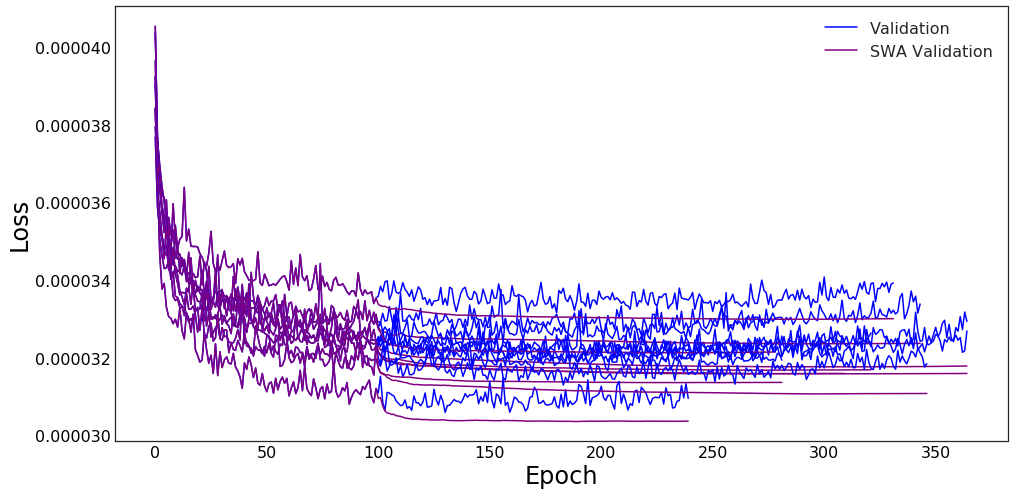

Mean loss = 3.17e-05 +- 2e-07
Mean wAUC = 0.063 +- 0.0009
Mean AUC = 0.0982 +- 0.0006
______________________________________



<Figure size 432x288 with 0 Axes>

In [10]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams, swaStart=100,
                                          patience=50, swaRenewal=-1, trainOnWeights=True, cosAnnealMult=0, reduxDecay=False,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"